In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.integrate
import os
import sys
#!{sys.executable} -m pip install geopy
import geopy.distance
import math
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rcParams
import scipy.ndimage

rcParams.update({'figure.autolayout': True})


In [6]:
def calculate_distance(df):
    distance = 0
    for i in range(1,len(df)):
        coords_1 = (df.position_y[i-1],df.position_x[i-1])
        coords_2 = (df.position_y[i],df.position_x[i])
        distance += geopy.distance.distance(coords_1, coords_2).km
    return distance  


def euler_from_quaternion(x, y, z, w):
    #Source https://automaticaddison.com/how-to-convert-a-quaternion-into-euler-angles-in-python/
    """
    Convert a quaternion into euler angles (roll, pitch, yaw)
    roll is rotation around x in radians (counterclockwise)
    pitch is rotation around y in radians (counterclockwise)
    yaw is rotation around z in radians (counterclockwise)
    """
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    roll_x = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    pitch_y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    yaw_z = math.atan2(t3, t4)

    return roll_x, pitch_y, yaw_z # in radians

def gaussian_filter(serie):
    sigma = 5
    return scipy.ndimage.filters.gaussian_filter(df.battery_current_husky,sigma)

def first_derivative(current, time):
    return [0] + list(np.diff(df.current_husky)/np.diff(df.time))

def isvaring(array):
    var = False
    for i in array:
        if np.fabs(i) > 2:
            var = True
    #print(var)
    return var

def find_index(diff_current):
    index = 0
    n = 30
    mean = np.mean(np.fabs(np.array(diff_current[index:index+n])))
    var = isvaring(diff_current[index:index+n])
    while (np.fabs(mean) > 0.5) or (var):
        index += 1
        mean = np.mean(np.array(diff_current[index:index+n]))
        var = isvaring(diff_current[index:index+n])
    #print(mean)
    return index

def current_correction(df):
    df['current_husky'] = gaussian_filter(df.battery_current_husky)
    slope = first_derivative(df.current_husky, df.time)
    index = find_index(slope)
    n = 20
#     print(index)
#     plt.plot(df.time, df.battery_current_husky)
#     plt.scatter(df.loc[df.index[0] + index:df.index[0] + index+n, 'time'], 
#                df.loc[df.index[0] + index:df.index[0] + index+n, 'battery_current_husky'], color='orange')
#     plt.ylim(-1, 1)
#     plt.xlim(0,50)
#     plt.show()
    
#     print(test, df.loc[df.index[0] + index:df.index[0] + index+n, 'battery_current_husky'].mean())
    current = df['battery_current_husky'] - df.loc[df.index[0] + index:df.index[0] + index+n, 'battery_current_husky'].mean()
#     print(test, df.loc[df.index[0] + index:df.index[0] + index+n, 'battery_current_husky'].mean())  
    counter = 0
    for i in range(len(current)):
        if current[i] < 0:
            current[i] = 0
            counter += 1
    print(counter)
    return current

In [7]:
data = pd.read_csv("data/dataset.csv", low_memory=False)

In [8]:
print("variables:",len(data.columns))
print("rows:",len(data))
print("tests:",len(set(data.test)))

variables: 27
rows: 386369
tests: 92


3030


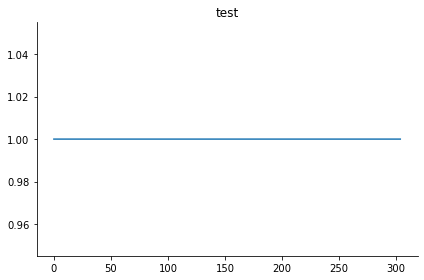

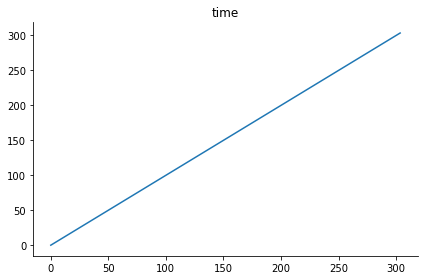

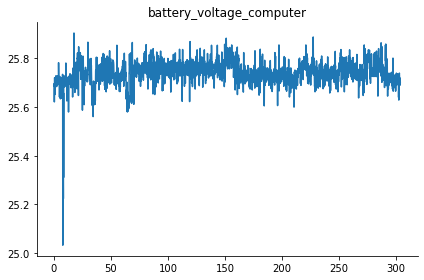

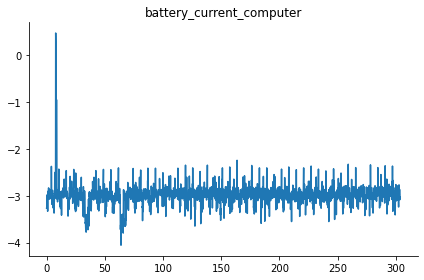

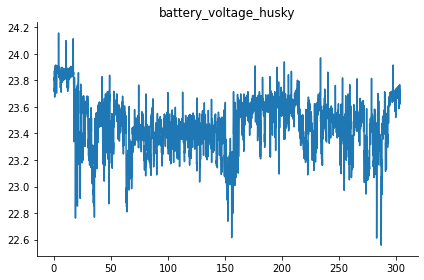

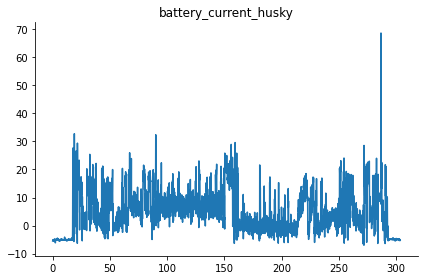

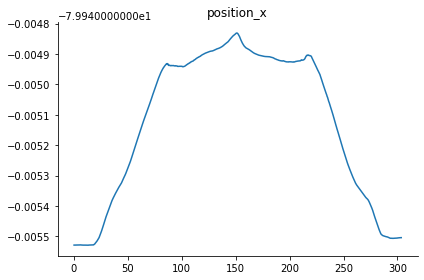

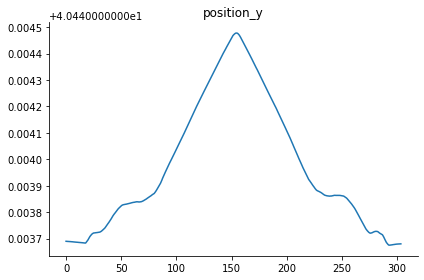

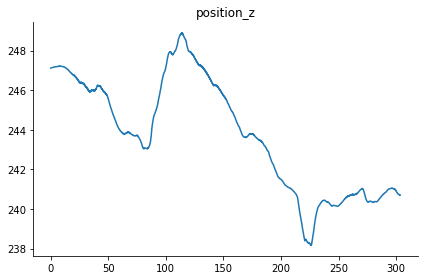

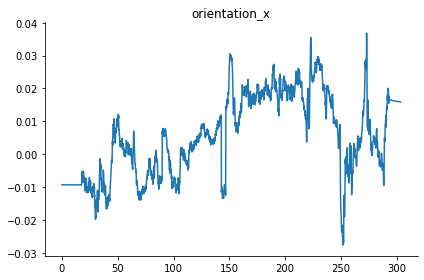

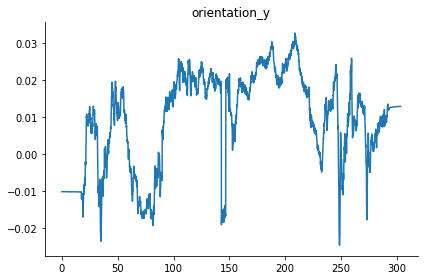

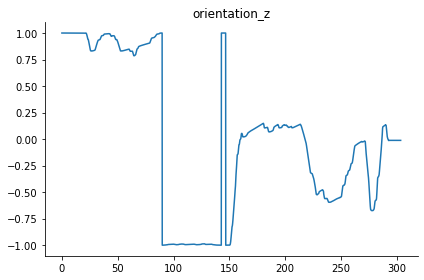

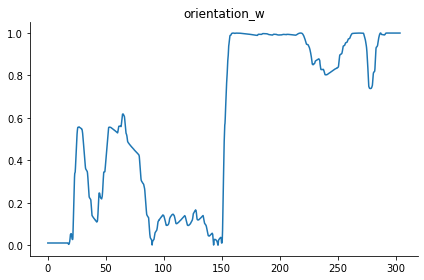

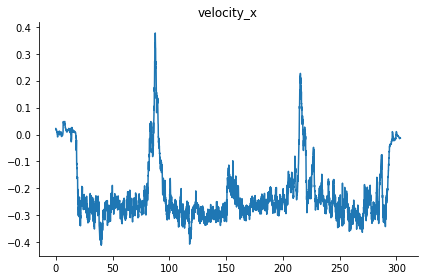

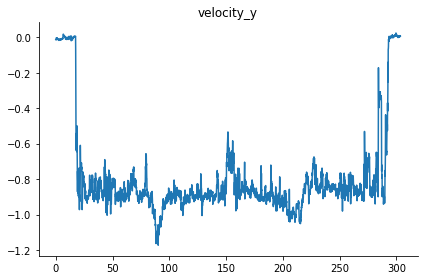

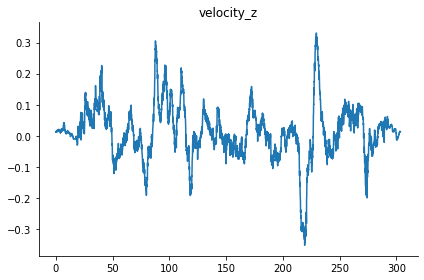

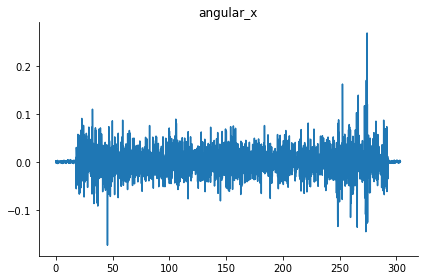

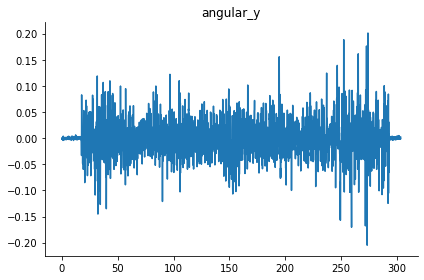

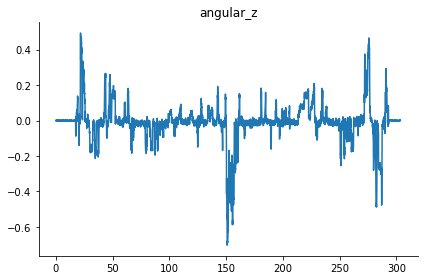

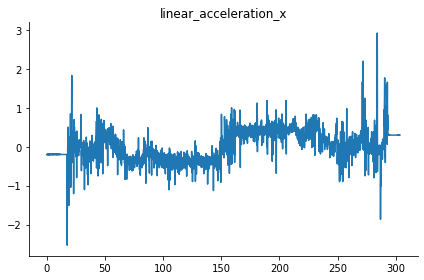

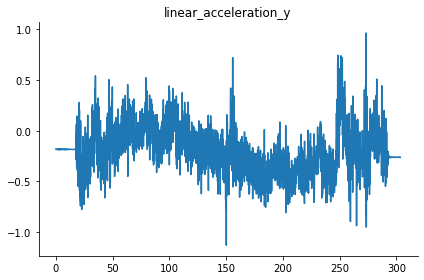

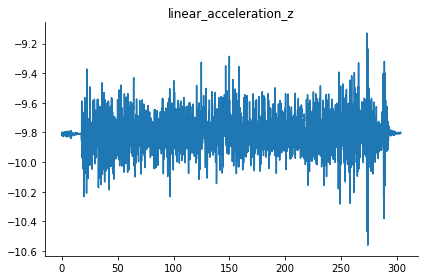

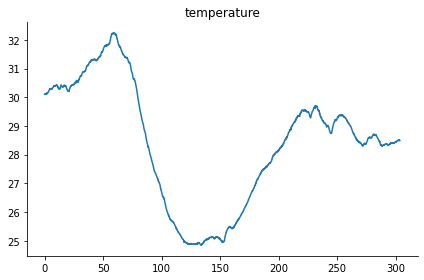

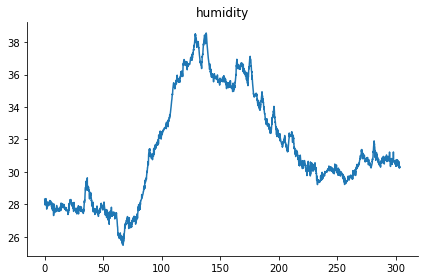

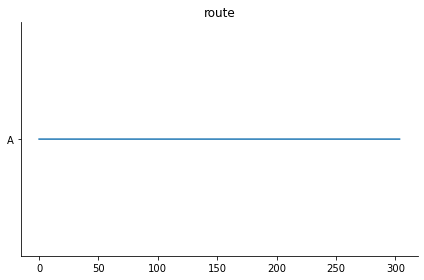

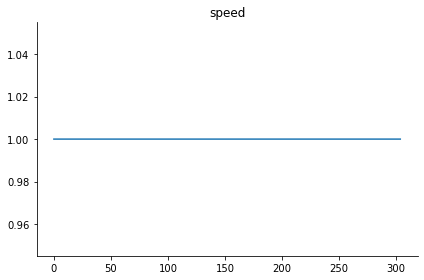

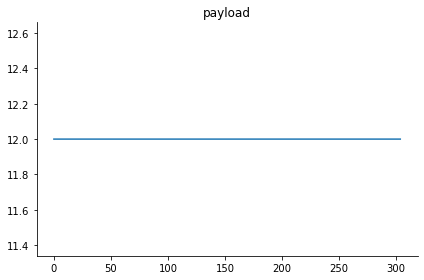

In [9]:
df = data[data.test==1].copy()
print(len(df))
for col in df.columns:
    plt.plot(df.time, df[col])
    plt.title(col)
    sns.despine(top=True, right=True)
    plt.show()

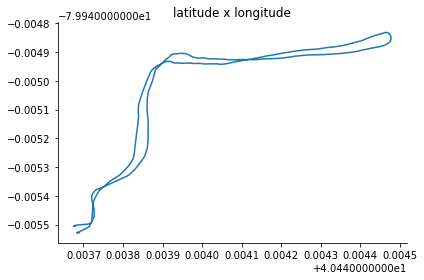

In [10]:
plt.plot(df.position_y, df.position_x)
plt.title("latitude x longitude")
sns.despine(top=True, right=True)
plt.show()

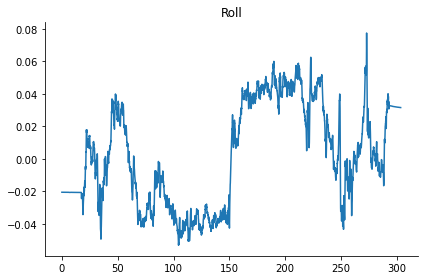

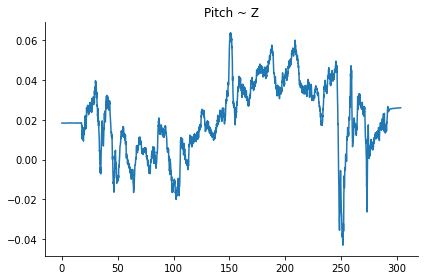

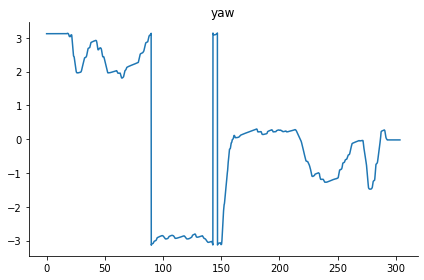

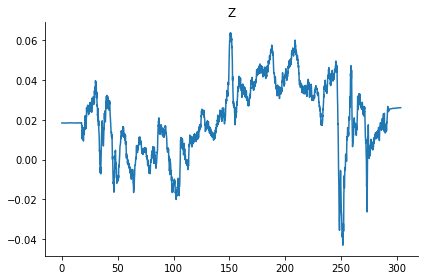

In [11]:
roll = []
pitch = []
yaw = []
counter = 0
for i in range(len(df)):
    counter += 1
    x = df.orientation_x[i]
    y = df.orientation_y[i]
    z = df.orientation_z[i]
    w = df.orientation_w[i]
    roll_x, pitch_y, yaw_z = euler_from_quaternion(x, y, z, w)
    roll.append(roll_x)
    pitch.append(pitch_y)
    yaw.append(yaw_z)
df['roll'] = roll
df['pitch'] = pitch
df['yaw'] = yaw    

plt.plot(df.time, df.roll)
plt.title("Roll")
sns.despine(top=True, right=True)
plt.show()

plt.plot(df.time, df.pitch)
plt.title("Pitch ~ Z")
sns.despine(top=True, right=True)
plt.show()

plt.plot(df.time, df.yaw)
plt.title("yaw")
sns.despine(top=True, right=True)
plt.show()


df['Z'] = np.arctan(df.pitch)
plt.plot(df.time, df.Z)
plt.title("Z")
sns.despine(top=True, right=True)
plt.show()



79


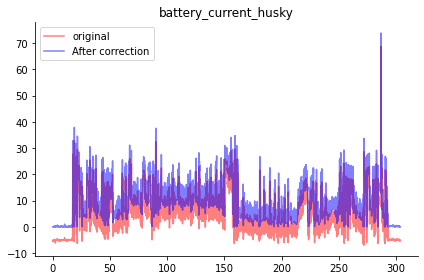

In [12]:
df['current'] = current_correction(df)


plt.plot(df.time, df.battery_current_husky, alpha=0.5, color='red', label="original")

plt.plot(df.time, df.current, alpha=0.5, color='blue', label='After correction')
plt.title("battery_current_husky")
plt.legend()
sns.despine(top=True, right=True)
plt.show()


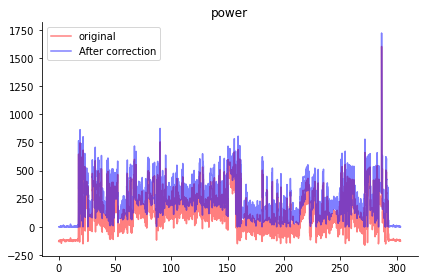

In [13]:
df['power'] = df.current*df.battery_voltage_husky
plt.plot(df.time, df.battery_current_husky*df.battery_voltage_husky, alpha=0.5, color='red', label="original")
plt.plot(df.time, df.power, alpha=0.5, color='blue', label='After correction')
plt.title("power")
plt.legend()
sns.despine(top=True, right=True)
plt.show()



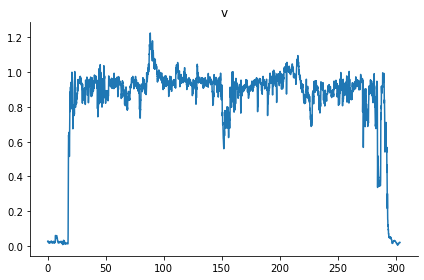

In [14]:
df['v'] = (df.velocity_x**2 + df.velocity_y**2 + df.velocity_z**2)**0.5
plt.plot(df.time, df.v)
plt.title("v")

sns.despine(top=True, right=True)
plt.show()


15


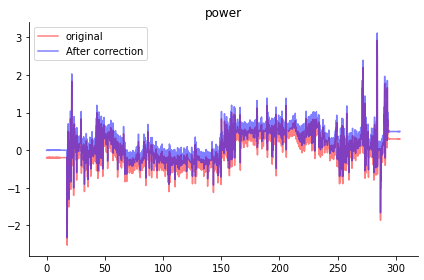

In [17]:
df1 = df.copy()
df['ax'] = ax
df['ay'] = ay
df['az'] = az
sigma=15
print(sigma)
df1.loc[:,'linear_acceleration_y'] = scipy.ndimage.filters.gaussian_filter(df1.loc[:,'linear_acceleration_y'],sigma)
df1.loc[:,'linear_acceleration_x'] = scipy.ndimage.filters.gaussian_filter(df1.loc[:,'linear_acceleration_x'],sigma)
df1.loc[:,'linear_acceleration_z'] = scipy.ndimage.filters.gaussian_filter(df1.loc[:,'linear_acceleration_z'],sigma)


df1 = df.loc[:50,:]
mean_ay = df1.linear_acceleration_y.mean()
mean_ax = df1.linear_acceleration_x.mean()
mean_az = df1.linear_acceleration_z.mean()

ay = df.loc[:,'linear_acceleration_y'] - mean_ay
ax = df.loc[:,'linear_acceleration_x'] - mean_ax
az = df.loc[:,'linear_acceleration_z'] - mean_az

plt.plot(df.time, df.linear_acceleration_x, alpha=0.5, color='red', label="original")
plt.plot(df.time, df.ax, alpha=0.5, color='blue', label='After correction')
plt.title("power")
plt.legend()
sns.despine(top=True, right=True)
plt.show()


    

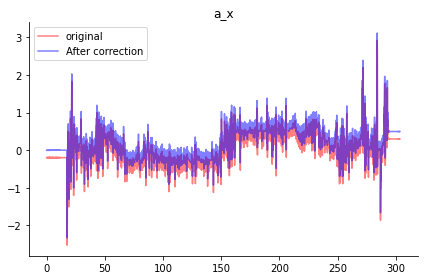

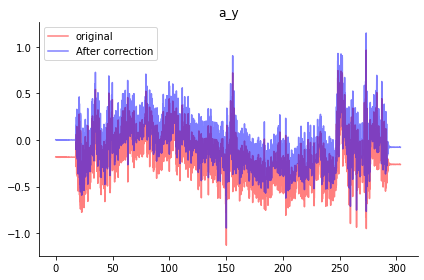

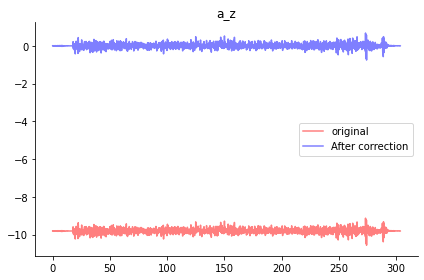

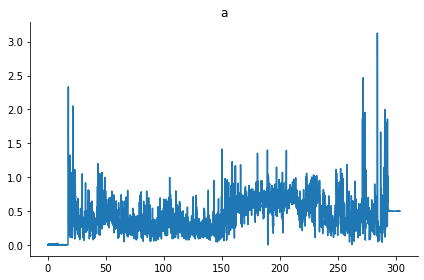

In [18]:
plt.plot(df.time, df.linear_acceleration_x, alpha=0.5, color='red', label="original")
plt.plot(df.time, df.ax, alpha=0.5, color='blue', label='After correction')
plt.title("a_x")
plt.legend()
sns.despine(top=True, right=True)
plt.show()

plt.plot(df.time, df.linear_acceleration_y, alpha=0.5, color='red', label="original")
plt.plot(df.time, df.ay, alpha=0.5, color='blue', label='After correction')
plt.title("a_y")
plt.legend()
sns.despine(top=True, right=True)
plt.show()

plt.plot(df.time, df.linear_acceleration_z, alpha=0.5, color='red', label="original")
plt.plot(df.time, df.az, alpha=0.5, color='blue', label='After correction')
plt.title("a_z")
plt.legend()
sns.despine(top=True, right=True)
plt.show()


df['a'] = (df.ax**2 + df.ay**2 + df.az**2)**0.5
plt.plot(df.time, df.a)
plt.title("a")
sns.despine(top=True, right=True)
plt.show()


In [19]:
roll = []
pitch = []
yaw = []
counter = 0
for i in range(len(data)):
    counter += 1
    x = data.orientation_x[i]
    y = data.orientation_y[i]
    z = data.orientation_z[i]
    w = data.orientation_w[i]
    roll_x, pitch_y, yaw_z = euler_from_quaternion(x, y, z, w)
    roll.append(roll_x)
    pitch.append(pitch_y)
    yaw.append(yaw_z)
data['roll_x'] = roll
data['pitch_y'] = pitch
data['yaw_z'] = yaw    

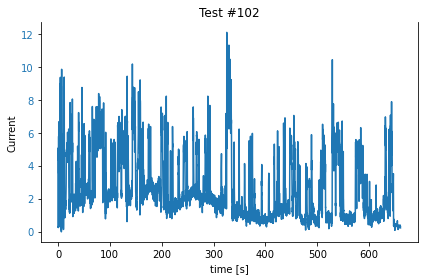

-0.0184052251279354


In [20]:
for test in [102]:
    df = data[data.test == test].copy()
    df = df.reset_index()
    
    pitch = np.degrees(df.pitch_y)
    roll = np.degrees(df.roll_x)
    yaw = np.degrees(df.yaw_z)
    
    fig, ax1 = plt.subplots()
    
    color = "tab:blue"
    ax1.set_xlabel('time [s]')
    ax1.set_ylabel("Current")
    ax1.plot(df.time, df.battery_current_husky, color=color )
    ax1.tick_params(axis='y', labelcolor=color)

#     ax2 = ax1.twinx()

#     color = "tab:red"
#     ax2.set_ylabel("Voltage")
#     ax2.plot(df.time, df.battery_voltage_husky, color=color, alpha=0.5 )
#     ax2.tick_params(axis='y', labelcolor=color)

#     fig.tight_layout()
    sns.despine(top=True, right=False)
    plt.title("Test #%d"%(test))
    plt.show()
    print(df.battery_current_husky.min())
    

In [21]:
tests = list(set(data.test))
for test in tests:
    df = data.loc[(data.test==test)].copy()
    data.loc[data.test==test, 'battery_current_husky'] = current_correction(df)

79


KeyError: 0

In [ ]:
# data.loc[data.battery_current_husky < 0, 'battery_current_husky'] = 0  # Only 4% of the data remains < 0 
for test in tests:
    df = data.loc[(data.test==test)].copy()
    if df.battery_current_computer.min() < 0:
        correction = data.loc[data.test==test, 'battery_current_computer'] - df.battery_current_computer.min()
        data.loc[data.test==test, 'battery_current_computer'] = correction
        print(test,df.battery_current_computer.min(), data.loc[data.test==test, 'battery_current_computer'].min())

In [ ]:
# for test in tests:
#     df = data.loc[(data.test==test)].copy()
#     if df.battery_voltage_computer.min() < 0:
#         data.loc[data.test==test, 'battery_voltage_computer'] -= df.battery_voltage_computer.min()

In [ ]:
for test in [102]:
    df = data[data.test == test].copy()
    df = df.reset_index()
    
    pitch = np.degrees(df.pitch_y)
    roll = np.degrees(df.roll_x)
    yaw = np.degrees(df.yaw_z)
    
    fig, ax1 = plt.subplots()
    
    color = "tab:blue"
    ax1.set_xlabel('time [s]')
    ax1.set_ylabel("Current")
    ax1.plot(df.time, df.battery_current_husky, color=color )
    ax1.tick_params(axis='y', labelcolor=color)

#     ax2 = ax1.twinx()

#     color = "tab:red"
#     ax2.set_ylabel("Voltage")
#     ax2.plot(df.time, df.battery_voltage_husky, color=color, alpha=0.5 )
#     ax2.tick_params(axis='y', labelcolor=color)

#     fig.tight_layout()
    sns.despine(top=True, right=False)
    plt.title("Test #%d"%(test))
    plt.show()
    print(df.battery_current_husky.min())
    
   
    

In [ ]:
DF = data.copy()
tests = list(set(DF.test))
sigma = 1

for test in tests:
    df = DF.loc[DF.test == test].copy()
    df = df.reset_index()
    df1 = df.copy()
    df1.loc[:,'linear_acceleration_y'] = scipy.ndimage.filters.gaussian_filter(df1.loc[:,'linear_acceleration_y'],sigma)
    df1.loc[:,'linear_acceleration_x'] = scipy.ndimage.filters.gaussian_filter(df1.loc[:,'linear_acceleration_x'],sigma)
    df1.loc[:,'twist_linear_y'] = scipy.ndimage.filters.gaussian_filter(df1.loc[:,'twist_linear_y'],sigma)
    df1.loc[:,'twist_linear_x'] = scipy.ndimage.filters.gaussian_filter(df1.loc[:,'twist_linear_x'],sigma)
    df1.loc[:,'twist_linear_z'] = scipy.ndimage.filters.gaussian_filter(df1.loc[:,'twist_linear_z'],sigma)
    df1.loc[:,'linear_acceleration_z'] = scipy.ndimage.filters.gaussian_filter(df1.loc[:,'linear_acceleration_z'],sigma)
    
    
    df1 = df.loc[:50,:]
    mean_ay = df1.linear_acceleration_y.mean()
    mean_ax = df1.linear_acceleration_x.mean()
    mean_Vy = df1.twist_linear_y.mean()
    mean_Vx = df1.twist_linear_x.mean()
    mean_Vz = df1.twist_linear_z.mean()
    mean_az = df1.linear_acceleration_z.mean()
    
    ay = df.loc[:,'linear_acceleration_y'] - mean_ay
    ax = df.loc[:,'linear_acceleration_x'] - mean_ax
    df.loc[:,'twist_linear_y'] -= mean_Vy
    df.loc[:,'twist_linear_x'] -= mean_Vx
    df.loc[:,'twist_linear_z'] -= mean_Vz
    df.loc[:,'linear_acceleration_z'] -= mean_az
    
    
    plt.plot(df.time,df.linear_acceleration_z)
    plt.ylabel("acceleration (m/s2)")
    plt.xlabel("time (s)")
    plt.title("test #%d"%(test))
    plt.show()
    
    data.loc[data.test == test,"linear_acceleration_y"] -= mean_ay # overwriting original data
    data.loc[data.test == test,"linear_acceleration_x"] -= mean_ax # overwriting original data
    data.loc[data.test == test,"twist_linear_y"] -= mean_Vy # overwriting original data
    data.loc[data.test == test,"twist_linear_x"] -= mean_Vx # overwriting original data
    data.loc[data.test == test,"twist_linear_z"] -= mean_Vz # overwriting original data
    data.loc[data.test == test,"linear_acceleration_z"] -= mean_az # overwriting original data
    
    

In [ ]:
data['power'] = data.battery_current_husky*data.battery_voltage_husky
data['a'] = (data.linear_acceleration_y**2 + data.linear_acceleration_x**2)**0.5
data['a_total'] = (data.linear_acceleration_y**2 + data.linear_acceleration_x**2 + data.linear_acceleration_z**2)**0.5
data['V'] = (data.twist_linear_y**2 + data.twist_linear_x**2 + data.twist_linear_z**2)**0.5
data['Z'] = np.tan(data.pitch_y)

TF = []
for test in tests: 
    tf = [0]
    df = data.loc[data.test == test,:].copy()
    df = df.reset_index()  
    tf.extend(np.array(df.loc[1:len(df),'time']) - np.array(df.loc[0:len(df)-2,'time']))
    TF.extend(tf)
data['tf'] = TF

In [ ]:
os.chdir(r'C:\Users\thiag\Box\Thiago DOE Research\Delivery Robots\Paper\UGVs')
data.to_csv('data_husky.csv', index=False)

In [ ]:
data.columns

In [22]:
df1 = data[data.test==1]

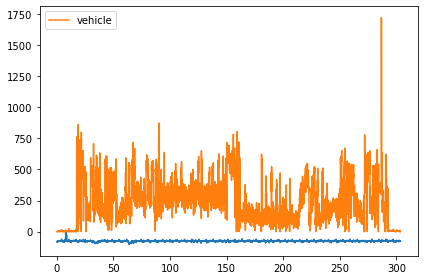

In [23]:
plt.plot(df1.time, df1.battery_voltage_computer*df1.battery_current_computer)
plt.plot(df1.time, df1.battery_voltage_husky*df1.battery_current_husky, label = 'vehicle')
plt.legend()
plt.show()

In [24]:
plt.plot(data.twist_linear_z)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'twist_linear_z'

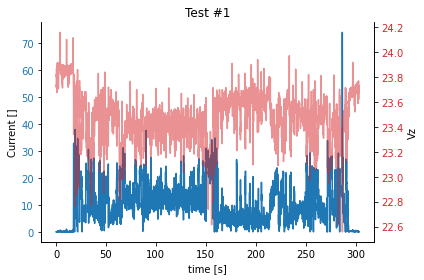

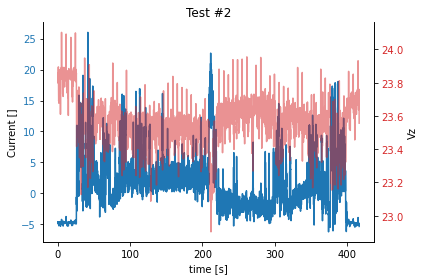

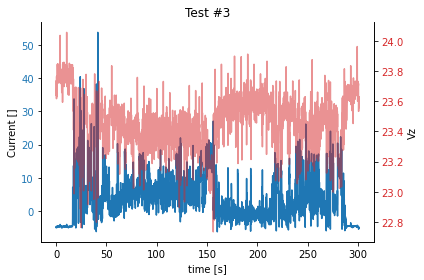

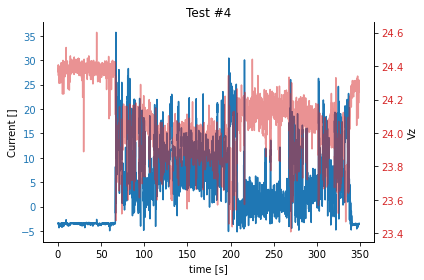

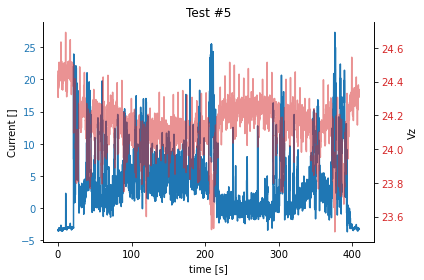

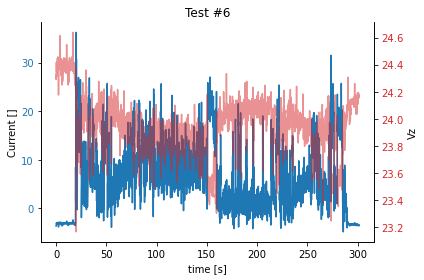

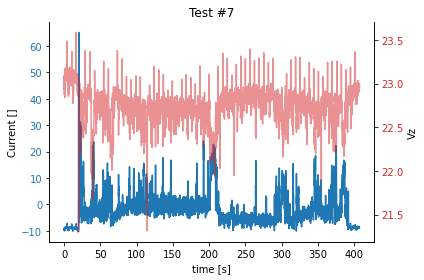

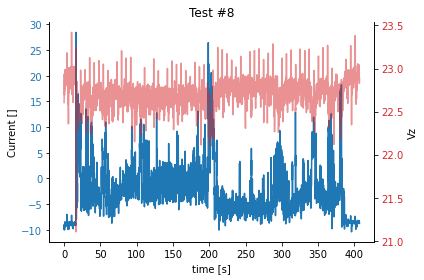

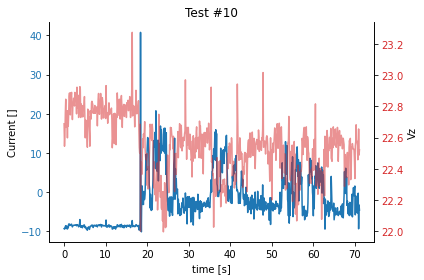

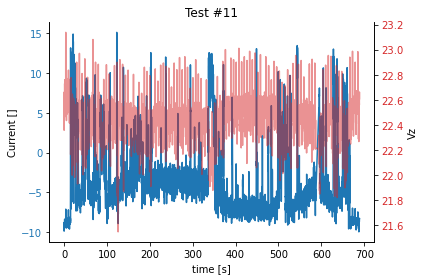

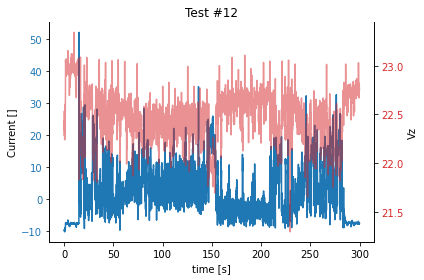

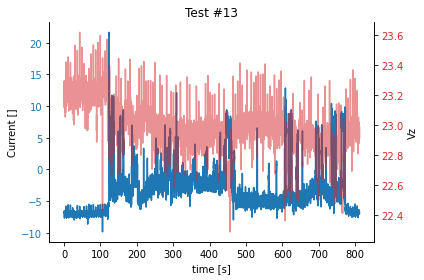

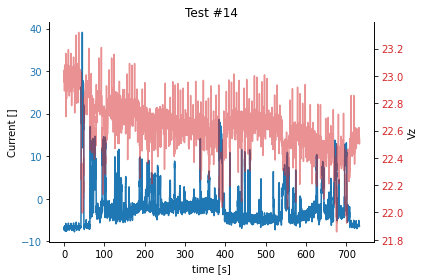

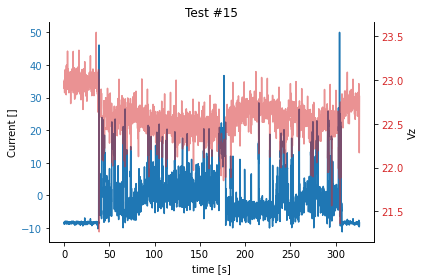

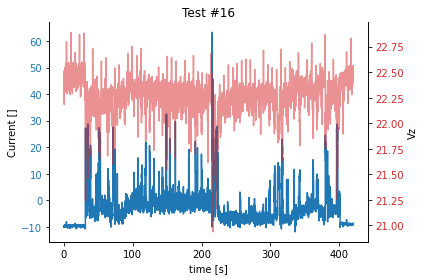

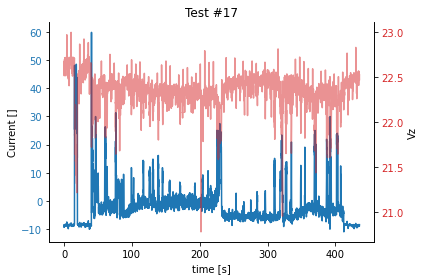

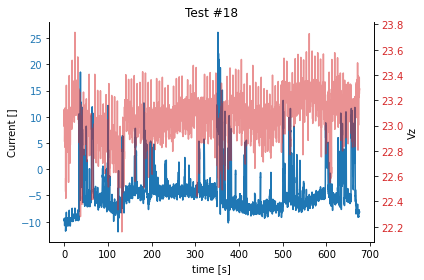

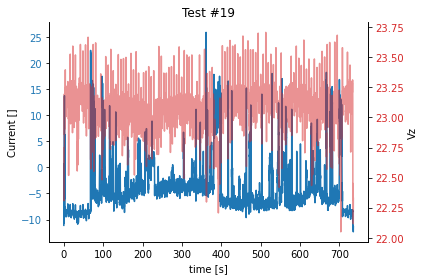

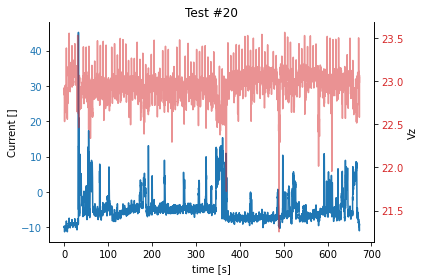

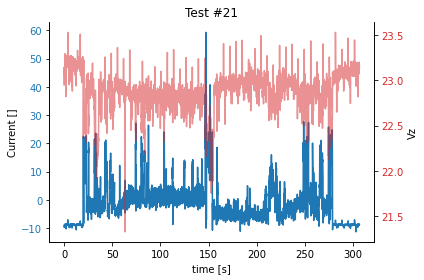

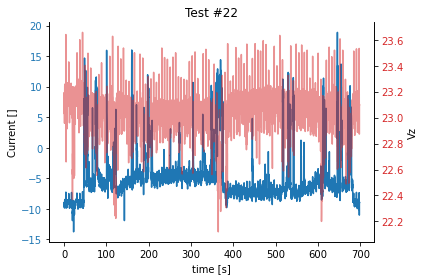

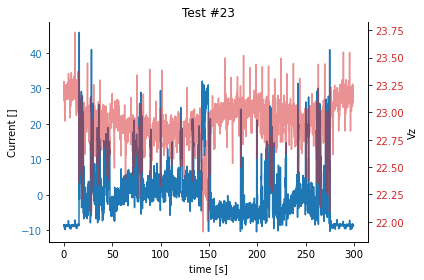

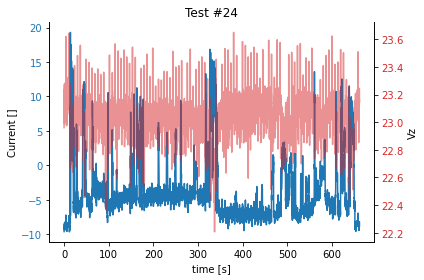

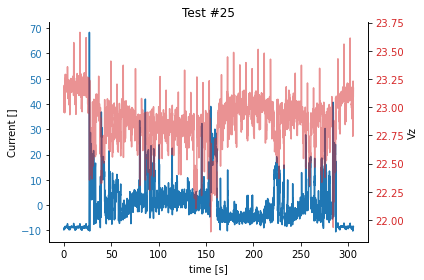

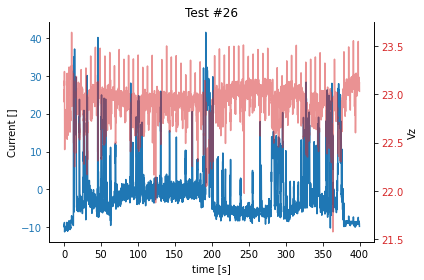

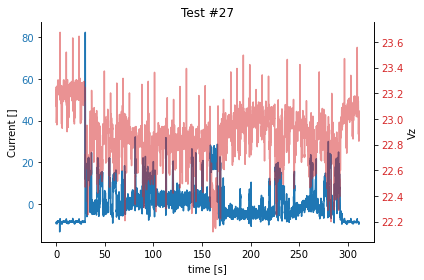

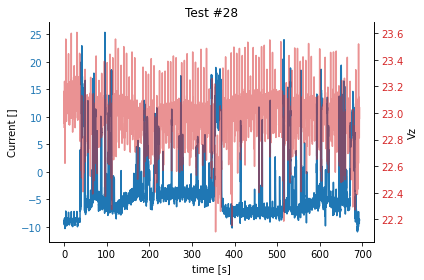

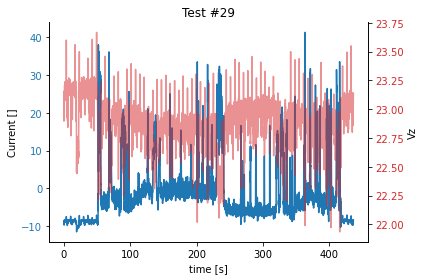

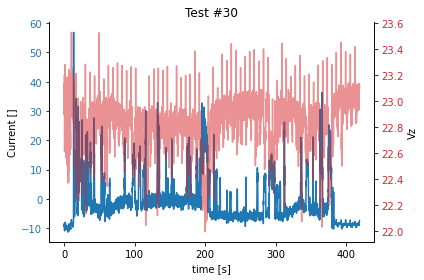

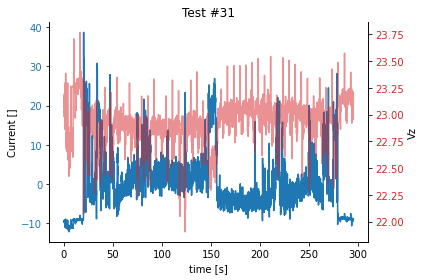

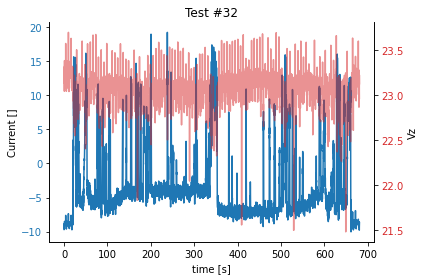

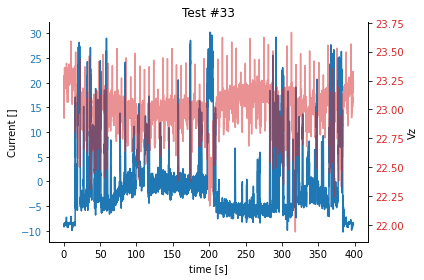

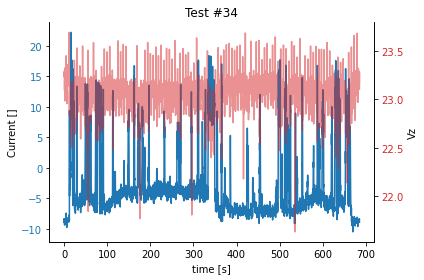

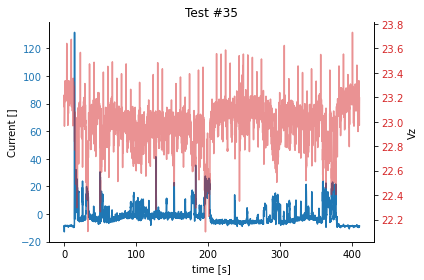

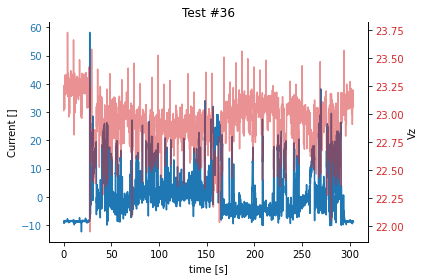

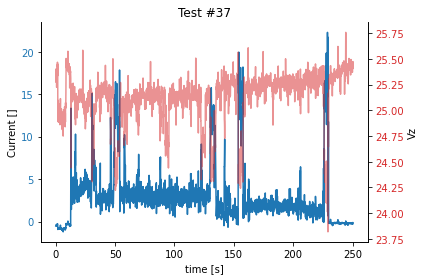

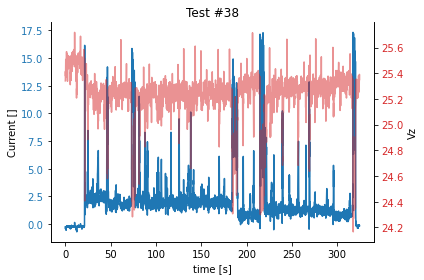

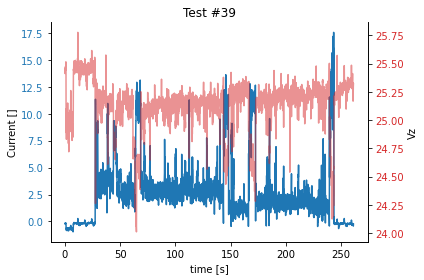

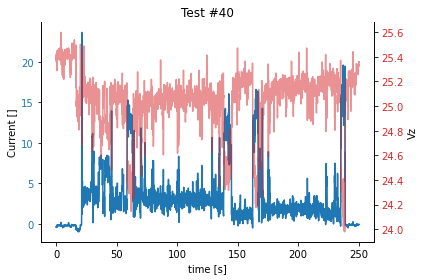

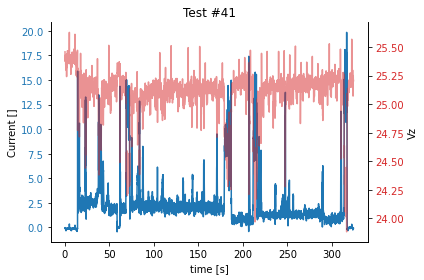

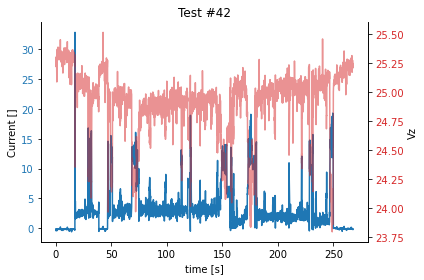

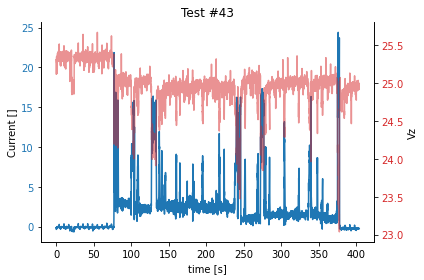

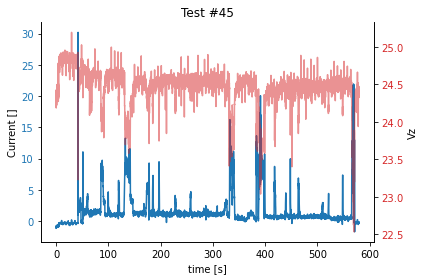

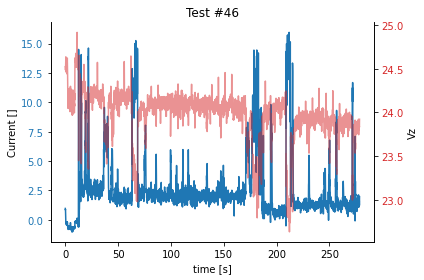

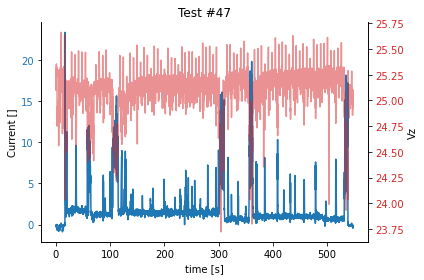

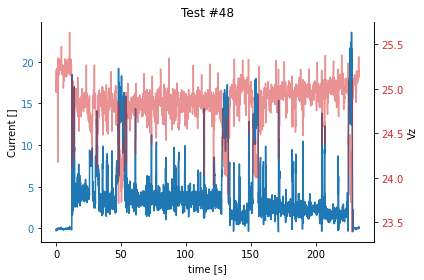

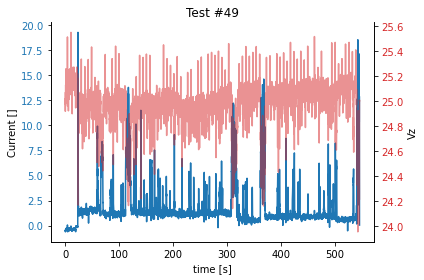

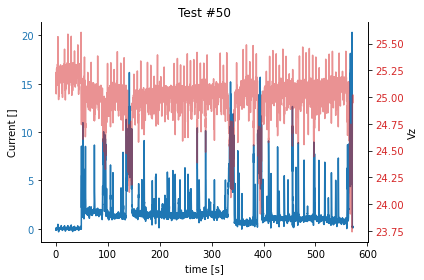

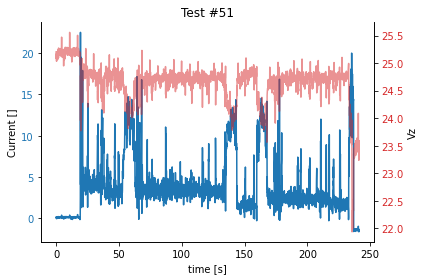

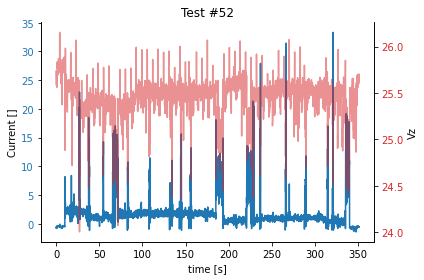

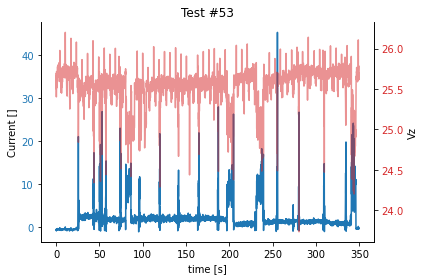

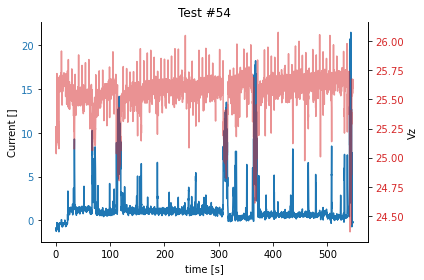

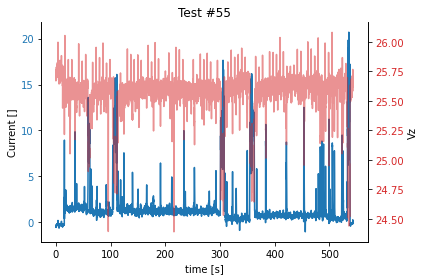

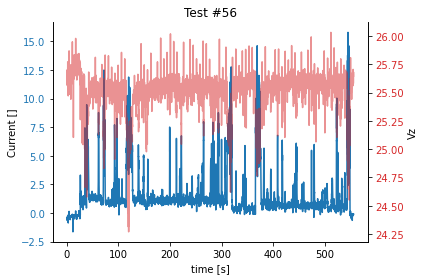

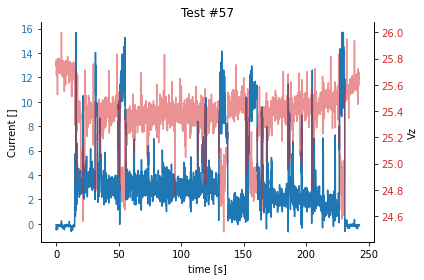

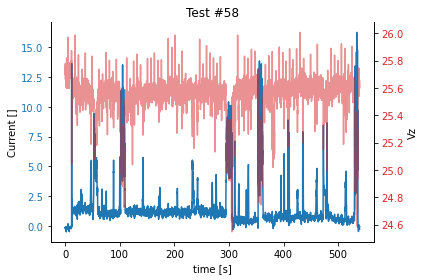

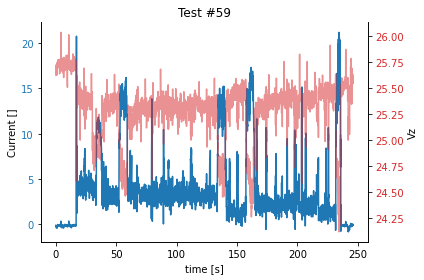

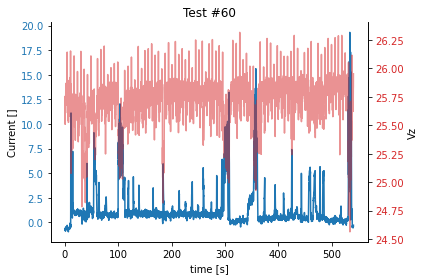

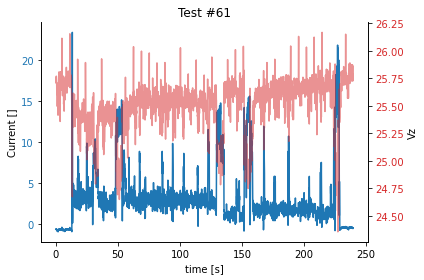

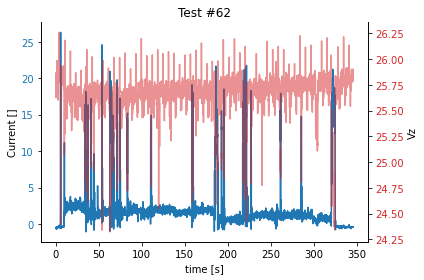

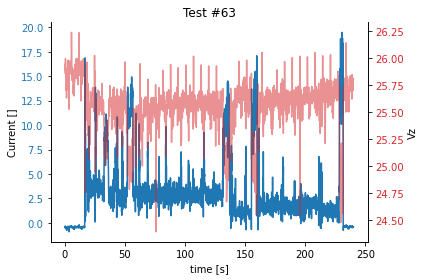

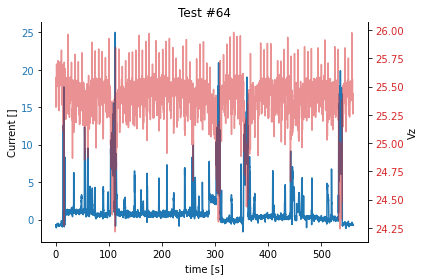

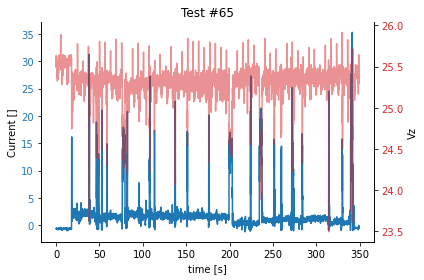

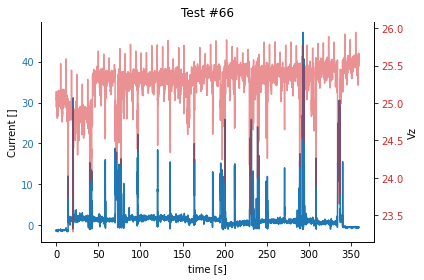

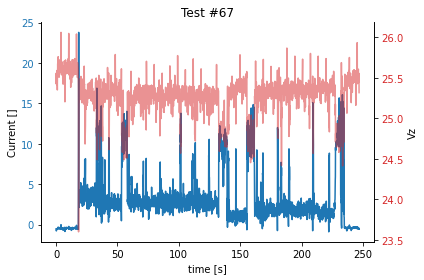

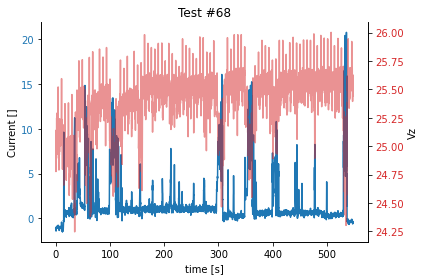

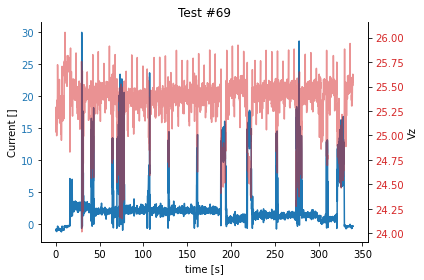

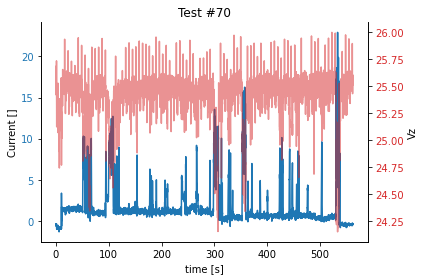

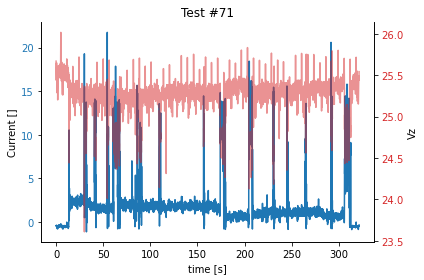

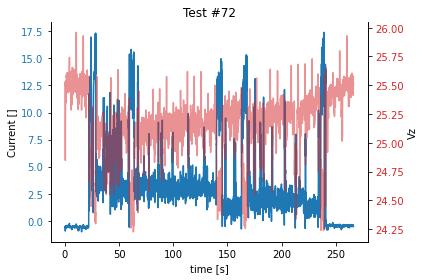

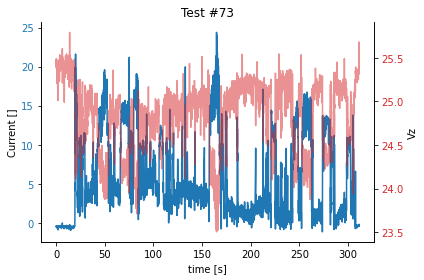

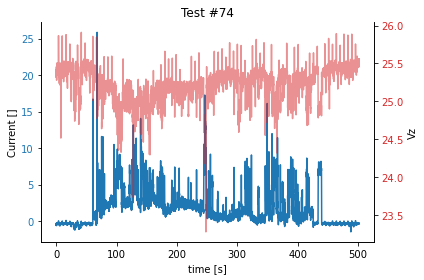

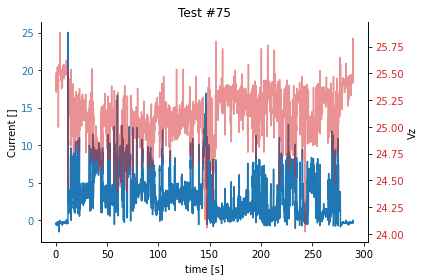

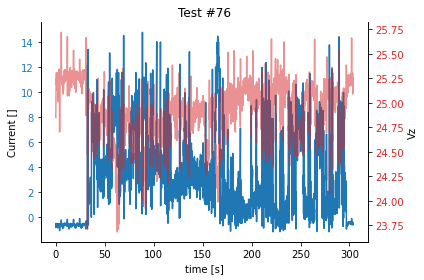

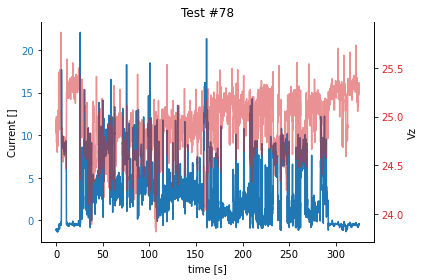

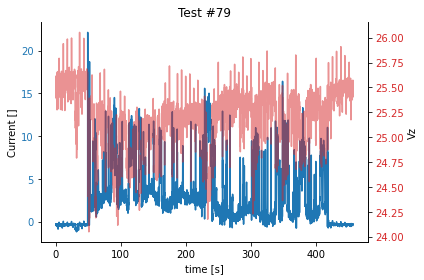

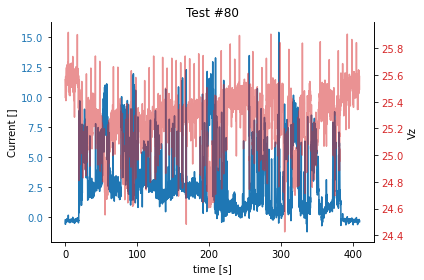

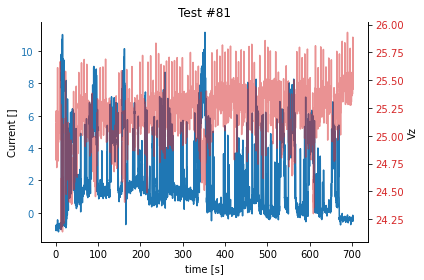

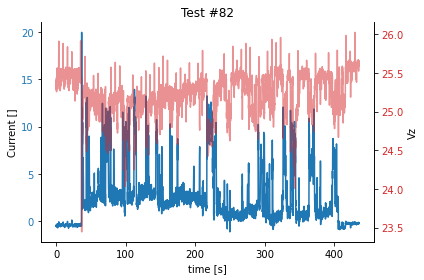

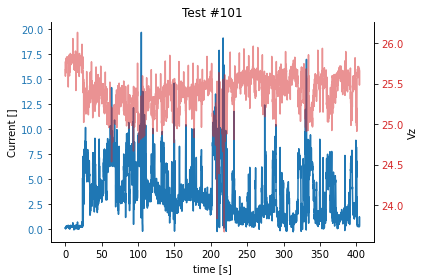

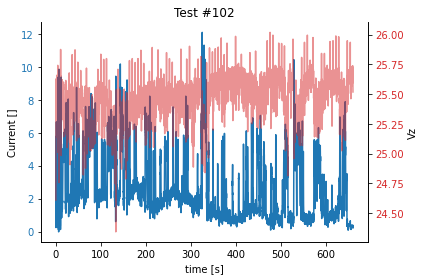

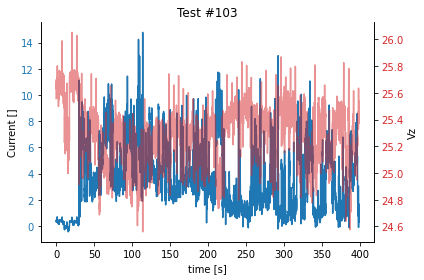

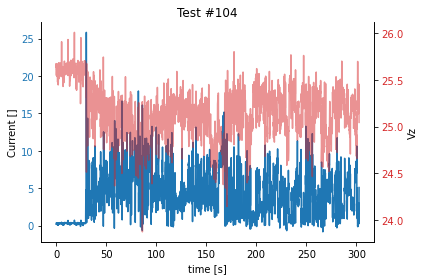

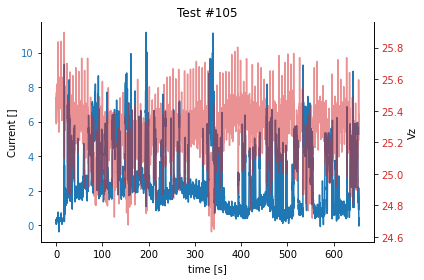

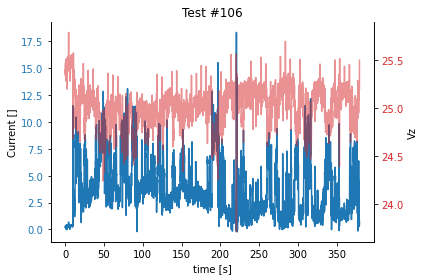

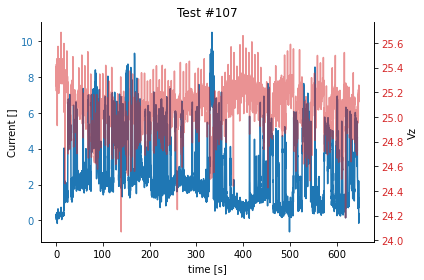

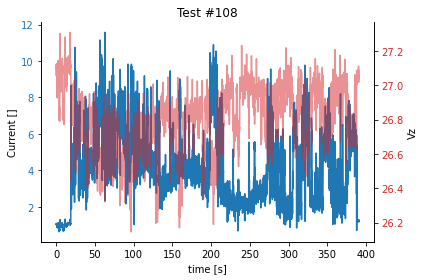

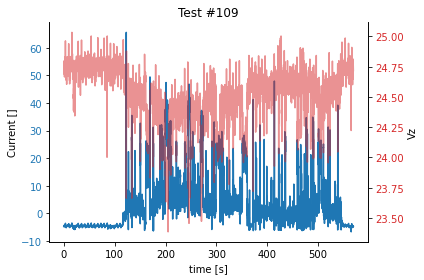

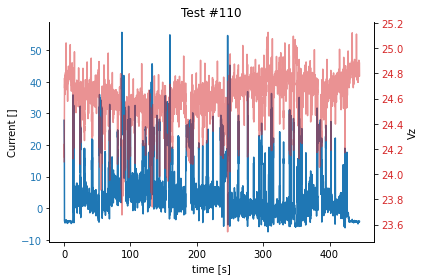

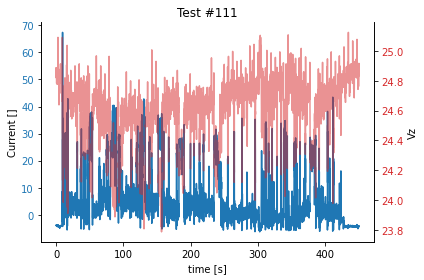

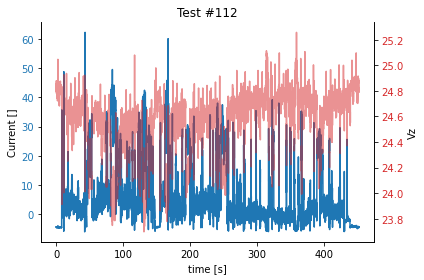

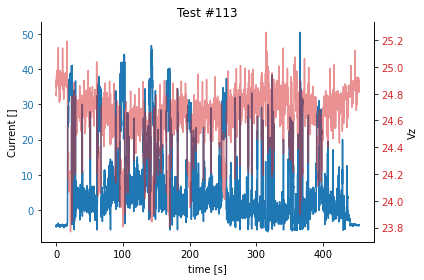

In [25]:
for test in tests:
    df = data[data.test == test].copy()
    df = df.reset_index()
    
    pitch = np.degrees(df.pitch_y)
    roll = np.degrees(df.roll_x)
    yaw = np.degrees(df.yaw_z)
    
    fig, ax1 = plt.subplots()
    
    color = "tab:blue"
    ax1.set_xlabel('time [s]')
    ax1.set_ylabel("Current []")
    ax1.plot(df.time, df.battery_current_husky, color=color )
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()

    color = "tab:red"
    ax2.set_ylabel("Vz")
    ax2.plot(df.time, df.battery_voltage_husky, color=color,alpha=0.5 )
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    sns.despine(top=True, right=False)
    plt.title("Test #%d"%(test))
    plt.show()
    
   
    


In [18]:
alpha = 30
np.tan(np.radians(alpha))

0.5773502691896257

In [19]:
import datetime
now = datetime.datetime.now()
now
onetime = datetime.datetime(2009, 1, 6, 15, 8, 24, 78915)
print(now)
time_to_run = "11:27:00"

2022-07-12 11:26:42.852916


In [24]:
time_to_run = "11:50:00"
while True:
    now = datetime.datetime.now()
    if now.strftime("%H:%M:%S") == time_to_run:
        print("Rodei")
    

Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rode

Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rode

Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rode

Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rode

Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rode

Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rodei
Rode

KeyboardInterrupt: 